# 1. A Béta függvény definiálása:

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WeightMethod():
    def __init__(self):
        self.theta = []
        
    def BetaWeights(self, params, nlags):
        self.theta.append(params[0])
        self.theta.append(params[1])
        eps = np.spacing(1)
        x = np.linspace(eps, 1.0 - eps, nlags)
        beta_vals = beta.pdf(x, self.theta[0], self.theta[1])/sum(beta.pdf(x, self.theta[0], self.theta[1]))
        return beta_vals
    
    def x_weighted_beta(self, x, params):
        w = WeightMethod().BetaWeights(params, x.shape[1])
        xw = np.matmul(x, w)
        return xw
    
    def ExpAlmonWeights(self, params, nlags):
        self.theta.append(params[0])
        self.theta.append(params[1])
        ith = np.arange(1, nlags + 1)
        almon_vals = np.exp(self.theta[0] * ith + self.theta[1] * ith ** 2)
        almon_vals = almon_vals / sum(almon_vals)
        return almon_vals
    
    def x_weighted_almon(self, y, params):
        w = WeightMethod().ExpAlmonWeights(params, x.shape[1])
        xw = np.matmul(x, w)
        return xw

Ábra létrehozása, ahol a theta = 1 és theta2 = 2,...,10 számolt súlyok. Hasonlóan mint ahogy a "Estimating MIDAS Regressions via OLS with Polynomial Parameter Profiling" cikkben a Figure 1-en látható, annyi kivétellel, hogy itt levannak osztva az értékek a szummázott súlyokkal.

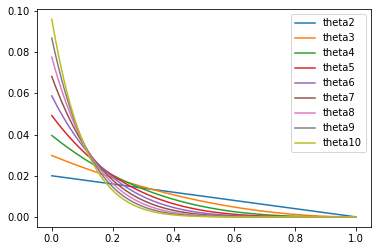

In [3]:
fig, ax = plt.subplots(1,1)

for i in range(2, 11):
    x = np.linspace(0, 1, 100)
    y = WeightMethod().BetaWeights([1., i], 100)
    ax.plot(x, y, label = 'theta' + str(i))
    
ax.legend(loc = 'best')
plt.show()

Ezen az ábrán meg a "Forecasting economic time series using score-driven dynamic models with mixed-data sampling" Figure 1 'Beta Lag' része.

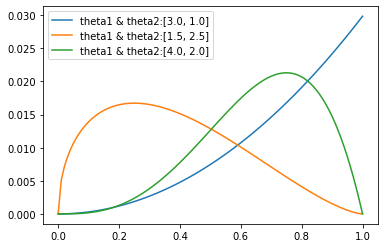

In [4]:
arr = [[3.0, 1.0], [1.5, 2.5], [4.0, 2.0]]

fig, ax = plt.subplots(1,1)

for i in arr:
    x = np.linspace(0, 1, 100)
    y = WeightMethod().BetaWeights(i, 100)
    ax.plot(x, y, label = 'theta1 & theta2:' + str(i))
    
ax.legend(loc = 'best')
plt.show()

Ugyanennek a cikknek a Figure 1-ben látható 'Almon Lag' része, viszont itt valami a kódolásban nem sikerülhetett. A megadott képlet alapján lett implementálva.

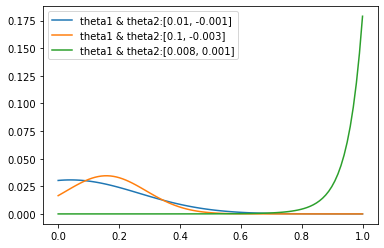

In [5]:
arr = [[0.01, -0.001], [0.1, -0.003], [0.008, 0.001]]

fig, ax = plt.subplots(1,1)

for i in arr:
    x = np.linspace(0, 1, 100)
    y = WeightMethod().ExpAlmonWeights(i, 100)
    ax.plot(x, y, label = 'theta1 & theta2:' + str(i))
    
ax.legend(loc = 'best')
plt.show()

# 2. Scipy Minimize Lineáris Regresszióra

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [7]:
df1 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Stocks/AMD.csv')
x = np.log(df1.close).diff().fillna(0)

df2 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Stocks/NVDA.csv')
y = np.log(df2.close).diff().fillna(0)

In [8]:
def f(x, params):
    return params[0] + params[1]*x
    
def fun(params):
    return sum((f(x, params) - y)**2)

In [9]:
init_params = np.array([1., 1.])

model = minimize(fun, init_params, method = 'L-BFGS-B')

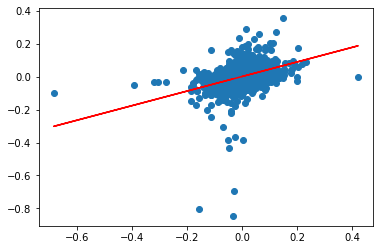

In [10]:
plt.scatter(x, y)
plt.plot(x, model.x[0] + model.x[1] * x, 'r-')
plt.show()

In [11]:
print('Beta0 és Beta1 értékei:',np.around(model.x, 3))

Beta0 és Beta1 értékei: [0.    0.443]


Ellenőrzésként egy sztenderd lineáris regresszióra is írtam kódot és ugyanazt az eredményt adta vissza:

In [12]:
class LinReg:
    def __init__(self, X, y):
        self.features = X
        self.output = y
        
    def coeff(self):
        ones = np.ones((len(self.output), 1))
        self.features = np.concatenate((ones, self.features), axis = 1)
        
        s1 = np.matmul(self.features.T, self.features)
        s2 = np.linalg.inv(s1)
        s3 = np.matmul(s2, self.features.T)
        self.beta = np.matmul(s3, self.output)
        
        return self.beta
    
    def performance(self):
        y_hat = np.matmul(self.features, self.beta)
        error = sum(self.output - y_hat)
            
        y_mean = sum(self.output)/len(self.output)
        r_square = sum((y_hat - y_mean)**2)/(sum((self.output - y_mean)**2))
            
        print('The R^2:', r_square)

In [13]:
x = x.values.reshape(x.shape[0], 1)

model2 = LinReg(x, y.values)
coeff = model2.coeff()
model2.performance()

The R^2: 0.1814628857791621


In [14]:
print('A Béták:',np.around(coeff, 3))

A Béták: [0.    0.443]


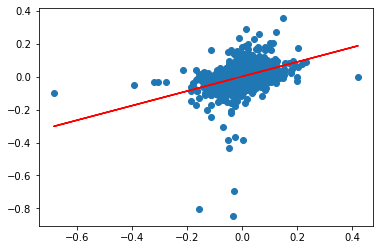

In [15]:
plt.scatter(x, y)
plt.plot(x, coeff[0] + coeff[1] * x, 'r-')
plt.show()

# 3. MIDAS:
## Az alacsony frekvenciájú idősorunk az Consumer Price Index változása, ami havi adatú
## A magas frekvenciájú idősorunk a CBOE Vix index változása, ami napi adatú

A lagok számát 20ra állítottam, és ahol nincs meg annyi adat ott a hiányzó adatokat már 0-val jelöltem, mivel az előzö havi adatokba már beépült az információ.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Minimizer, Parameters
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
df1 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Macroeconomic/CPIAUCSL.csv')
df1 = df1[-249:]
df1['Chg'] = np.log(df1.Value).diff().fillna(0)
df1 = df1.iloc[1:,:]

In [18]:
df2 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/Macroeconomic/VIXCLS.csv')
df2 = df2[-5434:-41]
df2 = df2[df2.VIXCLS != '.']
df2 = df2.reset_index(drop=True)
df2.VIXCLS = df2.VIXCLS.astype(float)
df2['Chg'] = np.log(df2.VIXCLS).diff().fillna(0)
df2['DATE'] = pd.to_datetime(df2.DATE)

per = df2.DATE.dt.to_period('M')
uniq = np.array(per.unique())

In [19]:
dd = {}
for j in range(len(uniq)):
    index = per[per == uniq[j].strftime('%Y-%m')].index.values
    arr = []
    for i in range(len(index) - 20, len(index)):
        try:
            arr.append(df2.Chg[df2.index == index[i]].values[0])
        except:
            arr.append(0.0)
    try:
        dd[uniq[j+1].strftime('%Y-%m')] = arr
    except:
        pass

In [20]:
vix = pd.DataFrame(dd)
vix = vix[::-1].reset_index(drop=True).T
vix = vix.iloc[1:,:].values

In [21]:
def f(var, x):
    return var[0] + var[1] * WeightMethod().x_weighted_beta(x, [var[2], var[3]])

def func(pars, x, data = None):
    a, b, c, d = pars['b0'], pars['b1'], pars['theta1'], pars['theta2']
    model = a + b * WeightMethod().x_weighted_beta(x, [c, d])
    if data is None:
        return model
    return model - data

In [22]:
params = Parameters()
params.add('b0', value = 10)
params.add('b1', value = 10)
params.add('theta1', value = 10)
params.add('theta2', value = 10)

init_pars = [2.5, 1.3, 0.8, 4.2]
y = f(init_pars, vix)
data = df1.Chg

In [23]:
min1 = Minimizer(func, params, fcn_args=(vix,), fcn_kws={'data':data})
out1 = min1.minimize(method = 'lbfgsb')
fit1 = func(out1.params, vix)

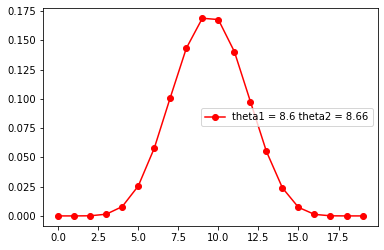

In [47]:
model_beta = WeightMethod().BetaWeights([out1.params['theta1'], out1.params['theta2']], vix.shape[1])

plt.plot(model_beta, 'ro-', label = 'theta1 = '+ str(round(out1.params['theta1'].value,2)) + ' theta2 = ' + str(round(out1.params['theta2'].value,2)))
plt.legend(loc = 'best')
plt.show()

In [33]:
print('R2 score of this model: ', round(r2_score(data, fit1), 6))
print('MSE of this model: ', round(mean_squared_error(data, fit1), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit1 - np.mean(fit1))), 6))

R2 score of this model:  0.016825
MSE of this model:  9e-06
Mean Absolute Deviation (MAD) of this model:  0.000279


In [54]:
print('''
==============================================
Statistic/Parameter|   Without   |
----------------------------------------------
N Function Calls   |   %3i       |
Chi-square         |   %.4f    |
   b0              |   %.4f    |
   b1              |   %.4f   |
   theta1          |   %.4f    |
   theta2          |   %.4f    |
----------------------------------------------
''' % (out1.nfev,
       out1.chisqr,
       out1.params['b0'],
       out1.params['b1'],
       out1.params['theta1'], 
       out1.params['theta2']))


Statistic/Parameter|   Without   |
----------------------------------------------
N Function Calls   |    60       |
Chi-square         |   0.0021    |
   b0              |   0.0017    |
   b1              |   -0.0215   |
   theta1          |   8.5980    |
   theta2          |   8.6617    |
----------------------------------------------



# U-MIDAS

In [44]:
model_u_midas = LinReg(vix, data)
coeff = model_u_midas.coeff()

In [45]:
fit2 = np.matmul(vix, coeff[1:])+coeff[0]

In [46]:
print('R2 score of this model: ', round(r2_score(data, fit2), 6))
print('MSE of this model: ', round(mean_squared_error(data, fit2), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit2 - np.mean(fit2))), 6))

R2 score of this model:  0.125862
MSE of this model:  8e-06
Mean Absolute Deviation (MAD) of this model:  0.000796
